### Optionally install required Python packages (uncomment lines as needed)

In [1]:
# !pip install requests
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly

### Set the URLs of the time-series service endpoints

In [2]:
service_base_url    = 'https://app.openskope.org/timeseries-service/api/v1'

status_endpoint     = service_base_url + "/status"
version_endpoint    = service_base_url + "/version"
timeseries_endpoint = service_base_url + "/timeseries"

### Exercise the the status and version endpoints

In [3]:
import requests

In [4]:
print(requests.get(status_endpoint).json())

{u'name': u'SKOPE Timeseries Service'}


In [5]:
print(requests.get(version_endpoint).text)

-----------------------------------------------------------------------------
SKOPE Time-Series Service v0.2.0-0 (branch master, commit 6c24801)
-----------------------------------------------------------------------------
Remote repo: https://github.com/openskope/timeseries-service.git
Git branch: master
Last commit: 6c2480145a827966c1bf9d2a57b8c0bf25d8c0e3
Commit time: 2018-05-07T21:37:24+0000
Most recent tag: v0.2.0
Commits since tag: 0
Builder name: 
Builder email: tmcphillips@absoluteflow.org
Build host: 460ae1080878
Build platform: Linux 4.4.0-93-generic (amd64)
Build Java VM: OpenJDK 64-Bit Server VM (Oracle Corporation)
Build Java version: JDK 1.8.0_171
Build time: 2018-05-07T22:41:33+0000



### Request the time series at a point in the PaleoCAR dataset

In [6]:
# build the request body
request_json = {  
    "datasetId": "paleocar_2",
    "variableName": "growing_degree_days",
    "start": 1, 
    "end": 2000, 
    "timeResolution": 'year', 
    "timeZero": 1, 
    "boundaryGeometry": {
        "type": "Point",
        "coordinates": [-106.0,41.0]
    }
}

# make the post request and store the response
response = requests.post(timeseries_endpoint, json=request_json)

# confirm that the request was successful
assert response.status_code == 200

In [7]:
# get the body of the response as JSON
response_json = response.json()

# confirm that the metadata in the response is as expected
assert response_json['datasetId']    == 'paleocar_2'
assert response_json['variableName'] == 'growing_degree_days'
assert response_json['start']        == '1'
assert response_json['end']          == '2000'
assert response_json['startIndex']   == 0
assert response_json['endIndex']     == 1999

# confirm that the values and confidence interval bound lists are of the expected size
assert len(response_json['values'])       == 2000
assert len(response_json['upperBounds'])  == 2000
assert len(response_json['lowerBounds'])  == 2000

### Load response csv property into a Pandas dataframe

In [8]:
import pandas as pd
from io import StringIO

csv = StringIO(response_json['csv'])
df = pd.read_csv(csv)
print(df.head(10))

   year   growing_degree_days   range -   range +
0     1                  1775    1758.0    1792.0
1     2                  1823    1806.0    1840.0
2     3                  1846    1829.0    1863.0
3     4                  1870    1853.0    1887.0
4     5                  1820    1803.0    1837.0
5     6                  1833    1816.0    1850.0
6     7                  1801    1784.0    1818.0
7     8                  1682    1665.0    1699.0
8     9                  1631    1614.0    1648.0
9    10                  1701    1684.0    1718.0


In [9]:
print(df.tail(10))

      year   growing_degree_days   range -   range +
1990  1991                  1502    1490.0    1514.0
1991  1992                  1236    1224.0    1248.0
1992  1993                  1329    1317.0    1341.0
1993  1994                  1530    1518.0    1542.0
1994  1995                  1573    1561.0    1585.0
1995  1996                  1492    1480.0    1504.0
1996  1997                  1556    1544.0    1568.0
1997  1998                  1290    1278.0    1302.0
1998  1999                  1565    1551.0    1579.0
1999  2000                  1604    1590.0    1618.0


### Pretty-print ten points in time series as a table

In [10]:
from IPython.display import display, HTML
display(HTML(df.to_html(max_rows=10,index=False)))

year,growing_degree_days,range -,range +
1,1775,1758.0,1792.0
2,1823,1806.0,1840.0
3,1846,1829.0,1863.0
4,1870,1853.0,1887.0
5,1820,1803.0,1837.0
1996,1492,1480.0,1504.0
1997,1556,1544.0,1568.0
1998,1290,1278.0,1302.0
1999,1565,1551.0,1579.0
2000,1604,1590.0,1618.0


### Create a static plot of the time series using Matplotlib

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
timeseries_values = response_json['values']

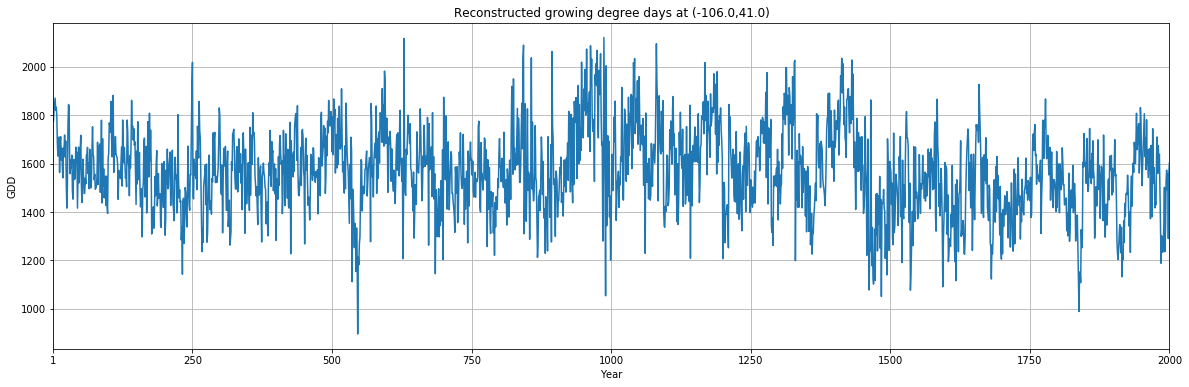

In [13]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
p = ax.plot(range(1,2001), timeseries_values[:2000])
ax.set_title("Reconstructed growing degree days at (-106.0,41.0)")
ax.set_xlabel("Year")
ax.set_ylabel("GDD")
ax.set_xlim(1,2000)
ax.set_xticks([1] + list(plt.xticks()[0][1:-1]) + [2000]);
ax.grid(True)

### Create an interactive plot with range slider using Plotly

In [14]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(rangeselector=dict(), rangeslider=dict())
)

fig = dict(
    data=[{"x":list(range(1,2001)), "y": timeseries_values[:2000]}], 
    layout=layout
)

iplot(fig)